### homework2：练习rnn的电影情感分类预测

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


准备数据

In [2]:
# !pip install tensorflow

In [3]:
from tensorflow import keras

#用karas有的数据集imdb，电影分类,分电影是积极的，还是消极的
imdb = keras.datasets.imdb
#载入数据使用下面两个参数
vocab_size = 10000  #词典大小，仅保留训练数据中前10000个最经常出现的单词，低频单词被舍弃
index_from = 3  #0,1,2,3空出来做别的事
#前一万个词出现词频最高的会保留下来进行处理，后面的作为特殊字符处理，
# 小于3的id都是特殊字符，下面代码有写
# 需要注意的一点是取出来的词表还是从1开始的，需要做处理
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=vocab_size, index_from=index_from)

2025-01-23 18:40:35.612130: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 18:40:35.623750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737628835.637970    3293 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737628835.642308    3293 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 18:40:35.657076: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
type(train_labels)

numpy.ndarray

In [5]:
type(train_data)

numpy.ndarray

In [6]:
train_data.shape  #每个样本是一段话，每个单词用一个数字表示

(25000,)

In [7]:
type(train_data[0])

list

In [8]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [9]:
len(train_data[0])

218

In [10]:
len(train_data[1])

189

In [11]:
train_labels[0:10]  #二分类

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [12]:
print("train", train_data.shape, train_labels.shape)
print("test", test_data.shape, test_labels.shape)

train (25000,) (25000,)
test (25000,) (25000,)


In [13]:
#载入词表，看下词表长度，词表就像英语字典
word_index = imdb.get_word_index()
print(len(word_index))
print(type(word_index))
#词表虽然有8万多，但是我们只载入了最高频的1万词！！！！

88584
<class 'dict'>


构造 word2idx 和 idx2word

In [14]:
word2idx = {word: idx + 3 for word, idx in word_index.items()}
word2idx.update({
    "[PAD]": 0,  # 填充 token
    "[BOS]": 1,  # begin of sentence
    "[UNK]": 2,  # 未知 token
    "[EOS]": 3,  # end of sentence
})

idx2word = {idx: word for word, idx in word2idx.items()}

In [15]:
print(word2idx["hello"])

4825


In [16]:
idx2word[4]

'the'

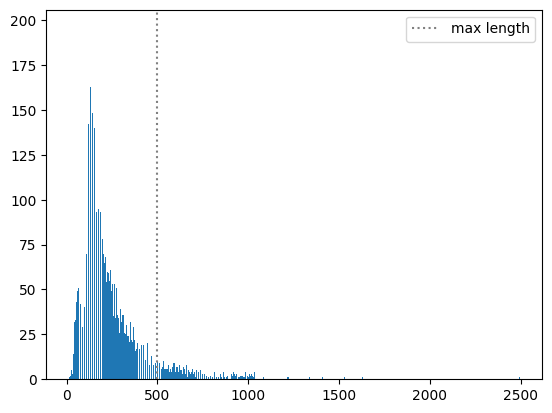

In [17]:
# 选择 max_length
length_collect = {}
for text in train_data:
    length = len(text)
    length_collect[length] = length_collect.get(length, 0) + 1

MAX_LENGTH = 500
plt.bar(length_collect.keys(), length_collect.values())
plt.axvline(MAX_LENGTH, label="max length", c="gray", ls=":")
plt.legend()
plt.show()

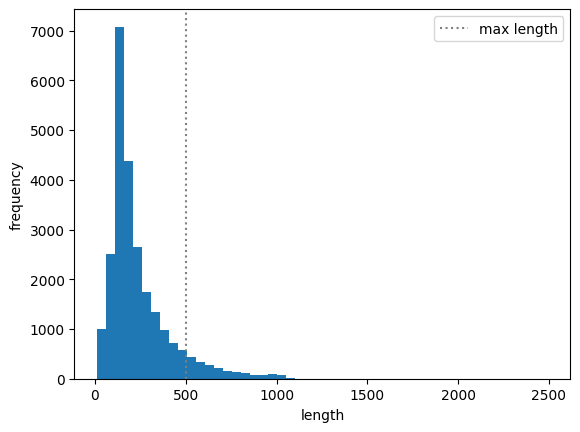

In [18]:
#想对句子长度画个直方图，看看长度分布
length_list = [len(text) for text in train_data]
plt.hist(length_list, bins=50)
plt.xlabel("length")
plt.ylabel("frequency")
plt.axvline(MAX_LENGTH, label="max length", c="gray", ls=":")
plt.legend()
plt.show()

In [19]:
length_list[0:10]

[218, 189, 141, 550, 147, 43, 123, 562, 233, 130]

In [20]:
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
raw_text

[['hello', 'world'],
 ['tokenize', 'text', 'datas', 'with', 'batch'],
 ['this', 'is', 'a', 'test']]

## Tokenizer


In [21]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx  #词表,单词到id
        self.idx2word = idx2word  #词表，id到单词
        self.max_length = max_length
        self.pad_idx = pad_idx  #填充
        self.bos_idx = bos_idx  #开始
        self.eos_idx = eos_idx  #结束
        self.unk_idx = unk_idx  #未知，未出现在最高频词表中的词

    def encode(self, text_list, padding_first=False):
        """将文本列表编码为索引张量。
    
        参数:
            text_list (list of str): 需要编码的文本列表。
            padding_first (bool): 如果为True，则在前面填充；否则在后面填充。
    
        返回:
            torch.Tensor: 包含编码后索引的张量。
        """
        # 计算最大长度，确保不超过self.max_length，并且至少为2（因为要包含BOS和EOS）
        max_length = min(self.max_length, 2 + max([len(text) for text in text_list]))

        # 用于存储每个文本的索引列表
        indices_list = []

        # 遍历每个文本
        for text in text_list:
            # 将文本转换为索引列表，包含BOS和EOS
            # 使用切片确保文本长度不超过max_length - 2（因为要留出位置给BOS和EOS）
            indices = [self.bos_idx] + [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - 2]] + [
                self.eos_idx]

            # 根据padding_first参数决定填充位置
            if padding_first:
                # 在前面填充pad_idx，直到达到max_length
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                # 在后面填充pad_idx，直到达到max_length
                indices = indices + [self.pad_idx] * (max_length - len(indices))

            # 将处理后的索引列表添加到indices_list中
            indices_list.append(indices)

        # 将indices_list转换为PyTorch张量并返回
        return torch.tensor(indices_list)

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        """
        将索引列表解码为文本列表。
    
        参数:
            indices_list (list of list of int): 某批次的索引列表，每个子列表是一个样本的索引序列。
            remove_bos (bool): 是否移除 BOS (Begin of Sentence) 标记。
            remove_eos (bool): 是否移除 EOS (End of Sentence) 标记。
            remove_pad (bool): 是否移除 PAD (Padding) 标记。
            split (bool): 如果为 True，返回的文本是单词列表；否则返回拼接后的字符串。
    
        返回:
            list of str or list of list of str: 解码后的文本列表。如果 split 为 False，返回字符串列表；否则返回单词列表。
        """
        text_list = []  # 用于存储解码后的文本列表

        # 遍历每个样本的索引列表
        for indices in indices_list:
            text = []  # 用于存储当前样本解码后的单词

            # 遍历当前样本的每个索引
            for index in indices:
                # 将索引转换为对应的单词，如果索引不在词汇表中，则返回 "[UNK]"
                word = self.idx2word.get(index, "[UNK]")

                # 如果 remove_bos 为 True 且当前单词是 BOS 标记，则跳过
                if remove_bos and word == "[BOS]":
                    continue

                # 如果 remove_eos 为 True 且当前单词是 EOS 标记，则停止解码
                if remove_eos and word == "[EOS]":
                    break

                # 如果 remove_pad 为 True 且当前单词是 PAD 标记，则停止解码
                if remove_pad and word == "[PAD]":
                    break

                # 将当前单词添加到文本中
                text.append(word)

            # 根据 split 参数决定返回格式
            if not split:
                # 如果 split 为 False，将单词列表拼接为字符串
                text_list.append(" ".join(text))
            else:
                # 如果 split 为 True，直接返回单词列表
                text_list.append(text)

        return text_list


# 初始化 Tokenizer 对象
tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)

# 定义原始文本数据，每个句子已经分词成单词列表
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]

# 使用 Tokenizer 的 encode 方法将原始文本编码为索引列表
# encode 方法支持批量处理，会自动添加 BOS、EOS 标记，并根据需要填充 PAD 标记
indices = tokenizer.encode(raw_text)

# 使用 Tokenizer 的 decode 方法将索引列表解码回文本
# 参数说明：
# - remove_bos=False: 保留 BOS 标记
# - remove_eos=False: 保留 EOS 标记
# - remove_pad=False: 保留 PAD 标记
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)

# 打印原始文本
print("raw text")
for raw in raw_text:
    print(raw)

# 打印编码后的索引列表
print("indices")
for index in indices:
    print(index)

# 打印解码后的文本
print("decode text")
for decode in decode_text:
    print(decode)

raw text
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
indices
tensor([   1, 4825,  182,    3,    0,    0,    0])
tensor([    1,     2,  3004,     2,    19, 19233,     3])
tensor([   1,   14,    9,    6, 2181,    3,    0])
decode text
[BOS] hello world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with batch [EOS]
[BOS] this is a test [EOS] [PAD]


In [22]:
train_data[0:1]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])],
      dtype=object)

In [23]:
# 看看训练集的数据
tokenizer.decode(train_data[0:1], remove_bos=False, remove_eos=False, remove_pad=False)

["[BOS] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

数据集与 DataLoader

In [42]:
from torch.utils.data import Dataset, DataLoader


class IMDBDataset(Dataset):
    def __init__(self, data, labels, remain_length=True):
        """
        初始化 IMDBDataset 类。

        参数:
            data (list of list of int): 编码后的文本数据，每个样本是一个索引列表。
            labels (list of int): 每个样本对应的标签。
            remain_length (bool): 是否保留原始长度（包括 BOS、EOS 和 PAD 标记）。
        """
        # 如果 remain_length 为 True，保留所有特殊标记（BOS、EOS、PAD）
        if remain_length:
            self.data = tokenizer.decode(data, remove_bos=False, remove_eos=False, remove_pad=False)
        else:
            # 如果 remain_length 为 False，移除特殊标记，缩减数据
            self.data = tokenizer.decode(data)

        # 存储标签
        self.labels = labels

    def __getitem__(self, index):
        """
        根据索引获取单个样本。

        参数:
            index (int): 样本的索引。

        返回:
            tuple: 包含文本和标签的元组。
        """
        # 获取指定索引的文本
        text = self.data[index]
        # 获取指定索引的标签
        label = self.labels[index]
        # 返回文本和标签
        return text, label

    def __len__(self):
        """
        返回数据集的大小。

        返回:
            int: 数据集中样本的数量。
        """
        return len(self.data)


def collate_fct(batch):
    """
    自定义的批处理函数，用于将一批样本整理为模型可用的格式。

    参数:
        batch (list of tuple): 一批样本，每个样本是一个元组 (text, label)。

    返回:
        tuple: 包含编码后的文本张量和标签张量的元组。
    """
    # 将 batch 中的文本和标签分别提取出来
    text_list = [item[0].split() for item in batch]  # 将每个文本字符串拆分为单词列表
    label_list = [item[1] for item in batch]  # 提取所有标签

    # 使用 tokenizer.encode 对文本列表进行编码
    # padding_first=True 表示在前面填充 PAD 标记
    text_list = tokenizer.encode(text_list, padding_first=True).to(dtype=torch.int)

    # 将标签列表转换为张量，并调整形状为 (batch_size, 1)
    label_list = torch.tensor(label_list).reshape(-1, 1).to(dtype=torch.float)

    # 返回编码后的文本张量和标签张量
    return text_list, label_list


# 用RNN，缩短序列长度
# remain_length=False: 表示在解码时移除特殊标记（如 BOS、EOS、PAD），缩减数据
# 创建训练数据集对象
train_ds = IMDBDataset(train_data, train_labels, remain_length=False)

# 创建测试数据集对象
test_ds = IMDBDataset(test_data, test_labels, remain_length=False)

In [43]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fct)  #collate_fn是处理batch的函数
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fct)

In [44]:
for text, label in train_dl:
    print(text.shape, label.shape)
    break

torch.Size([128, 500]) torch.Size([128, 1])


定义模型

In [45]:
class RNN(nn.Module):
    def __init__(self, embedding_dim=16, hidden_dim=64, vocab_size=vocab_size, num_layers=1, bidirectional=False):
        """
        初始化 RNN 模型。

        参数:
            embedding_dim (int): 词嵌入的维度。
            hidden_dim (int): RNN 隐藏层的维度。
            vocab_size (int): 词汇表的大小。
            num_layers (int): RNN 的层数。
            bidirectional (bool): 是否使用双向 RNN。
        """
        super(RNN, self).__init__()

        # 词嵌入层，将词汇索引映射为稠密向量
        self.embeding = nn.Embedding(vocab_size, embedding_dim)

        # RNN 层
        self.rnn = nn.RNN(
            embedding_dim,  # 输入特征的维度（词嵌入的维度）
            hidden_dim,  # 隐藏层的维度
            num_layers=num_layers,  # RNN 的层数
            batch_first=True,  # 输入数据的形状为 (batch_size, seq_length, embedding_dim)
            bidirectional=bidirectional  # 是否使用双向 RNN
        )

        # 线性层，用于将 RNN 的输出映射到隐藏层维度
        # 如果是双向 RNN，隐藏层维度需要乘以 2
        self.layer = nn.Linear(hidden_dim * (2 if bidirectional else 1), hidden_dim)

        # 全连接层，用于将隐藏层维度映射到输出维度（1，表示二分类）
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        定义前向传播过程。

        参数:
            x (torch.Tensor): 输入张量，形状为 [batch_size, seq_length]。

        返回:
            torch.Tensor: 输出张量，形状为 [batch_size, 1]。
        """
        # [batch_size, seq_length] -> [batch_size, seq_length, embedding_dim]
        # 将输入的词汇索引映射为词嵌入向量
        x = self.embeding(x)
        # [bs, seq length, embedding_dim] -> shape [bs, embedding_dim, seq length]
        # 将词嵌入向量输入 RNN 层
        # seq_output: RNN 的每个时间步的输出，形状为 [batch_size, seq_length, hidden_dim * (2 if bidirectional else 1)]
        # final_hidden: RNN 的最后一个时间步的隐藏状态，形状为 [num_layers * (2 if bidirectional else 1), batch_size, hidden_dim]
        seq_output, final_hidden = self.rnn(x)

        # print(f'seq_output.shape={seq_output.shape}')
        # print(f'final_hidden.shape={final_hidden.shape}')

        # 取最后一个时间步的输出
        # 这里假设 padding_first=True，即填充部分在前面，最后一个时间步是有效数据的最后一个时间步
        x = seq_output[:, -1, :]  # [batch_size, hidden_dim * (2 if bidirectional else 1)]

        # 将 RNN 的输出通过线性层映射到隐藏层维度
        x = self.layer(x)  # [batch_size, hidden_dim]

        # 将隐藏层的输出通过全连接层映射到输出维度（1，表示二分类）
        x = self.fc(x)  # [batch_size, 1]
        
        return x

In [46]:
#做前向计算，看下输出的shape
model = RNN()
sample_inputs = torch.randint(0, vocab_size, (1, 500))
model(sample_inputs).shape

torch.Size([1, 1])

In [47]:
print("{:=^80}".format(" 单层单向 RNN "))
for key, value in RNN().named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

=================================== 单层单向 RNN ===================================
            embeding.weight             paramerters num: 160000
            rnn.weight_ih_l0            paramerters num: 1024
            rnn.weight_hh_l0            paramerters num: 4096
             rnn.bias_ih_l0             paramerters num: 64
             rnn.bias_hh_l0             paramerters num: 64
              layer.weight              paramerters num: 4096
               layer.bias               paramerters num: 64
               fc.weight                paramerters num: 64
                fc.bias                 paramerters num: 1


In [48]:
print("{:=^80}".format(" 双层单向 RNN "))
for key, value in RNN(num_layers=2).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

=================================== 双层单向 RNN ===================================
            embeding.weight             paramerters num: 160000
            rnn.weight_ih_l0            paramerters num: 1024
            rnn.weight_hh_l0            paramerters num: 4096
             rnn.bias_ih_l0             paramerters num: 64
             rnn.bias_hh_l0             paramerters num: 64
            rnn.weight_ih_l1            paramerters num: 4096
            rnn.weight_hh_l1            paramerters num: 4096
             rnn.bias_ih_l1             paramerters num: 64
             rnn.bias_hh_l1             paramerters num: 64
              layer.weight              paramerters num: 4096
               layer.bias               paramerters num: 64
               fc.weight                paramerters num: 64
                fc.bias                 paramerters num: 1


In [49]:
print("{:=^80}".format(" 单层双向 RNN "))
for key, value in RNN(bidirectional=True).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

=================================== 单层双向 RNN ===================================
            embeding.weight             paramerters num: 160000
            rnn.weight_ih_l0            paramerters num: 1024
            rnn.weight_hh_l0            paramerters num: 4096
             rnn.bias_ih_l0             paramerters num: 64
             rnn.bias_hh_l0             paramerters num: 64
        rnn.weight_ih_l0_reverse        paramerters num: 1024
        rnn.weight_hh_l0_reverse        paramerters num: 4096
         rnn.bias_ih_l0_reverse         paramerters num: 64
         rnn.bias_hh_l0_reverse         paramerters num: 64
              layer.weight              paramerters num: 8192
               layer.bias               paramerters num: 64
               fc.weight                paramerters num: 64
                fc.bias                 paramerters num: 1


In [50]:
print("{:=^80}".format(" 双层双向 RNN "))
for key, value in RNN(num_layers=2, bidirectional=True).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

=================================== 双层双向 RNN ===================================
            embeding.weight             paramerters num: 160000
            rnn.weight_ih_l0            paramerters num: 1024
            rnn.weight_hh_l0            paramerters num: 4096
             rnn.bias_ih_l0             paramerters num: 64
             rnn.bias_hh_l0             paramerters num: 64
        rnn.weight_ih_l0_reverse        paramerters num: 1024
        rnn.weight_hh_l0_reverse        paramerters num: 4096
         rnn.bias_ih_l0_reverse         paramerters num: 64
         rnn.bias_hh_l0_reverse         paramerters num: 64
            rnn.weight_ih_l1            paramerters num: 8192
            rnn.weight_hh_l1            paramerters num: 4096
             rnn.bias_ih_l1             paramerters num: 64
             rnn.bias_hh_l1             paramerters num: 64
        rnn.weight_ih_l1_reverse        paramerters num: 8192
        rnn.weight_hh_l1_reverse        paramerters num: 4096

训练

In [51]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())
        # 二分类
        preds = logits > 0
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [52]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [53]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [54]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [55]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits > 0

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [68]:
epoch = 20

# model = RNN()  # 单向单层 RNN
# model = RNN(bidirectional=True)  # 双向单层 RNN
# model = RNN(num_layers=2)  # 单向双层 RNN
model = RNN(bidirectional=True, num_layers=2)  # 双向双层 RNN

# 1. 定义损失函数 采用二进制交叉熵损失, 先sigmoid再计算交叉熵
loss_fct = F.binary_cross_entropy_with_logits
# loss_fct =nn.BCEWithLogitsLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/imdb-adding")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/imdb-adding", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)

In [69]:
model = model.to(device)
record = training(
    model,
    train_dl,
    test_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
)

100%|██████████| 3920/3920 [02:23<00:00, 27.29it/s, epoch=19]


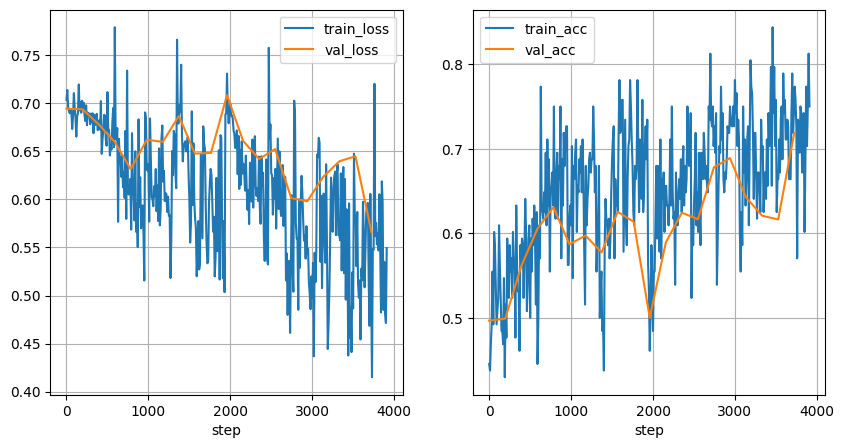

In [70]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10)  #横坐标是 steps

评估

In [71]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/imdb-adding/best.ckpt", weights_only=True, map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.5659
accuracy: 0.7187


***
#### 单向单层 RNN
- model = RNN()  
    - loss: 0.5264  
    - accuracy: 0.7602  
***
#### 双向单层 RNN
- model = RNN(bidirectional=True) 
    - loss: 0.5413
    - accuracy: 0.7410
***
#### 单向双层 RNN
- model = RNN(num_layers=2)  
    - loss: 0.5293
    - accuracy: 0.7646
***
#### 双向双层 RNN
- model = RNN(bidirectional=True, num_layers=2)  
    - loss: 0.5659
    - accuracy: 0.7187
***

|| **单向单层** | **双向单层** | **单向双层** | **双向双层** |
|------|----------|----------|----------|----------|
|loss| 0.5264   | 0.5413   | 0.5293   | 0.5659   |
|accuracy| 0.7602   | 0.7410   | 0.7646   | 0.7187   |